In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Introduction

Data can be transformed into knowledge and then enhanced intelligence. We use the titanic datasets to explore first its features. The Titanic datasets contains the records of the Titanic passengers during its maiden voyage and tragic demise.  

We apply some data engineering techniques to prepare various machine learning techniques - including logistic regression, decision trees, random forrests, KNN and artificial neural network - for the purpose of predicting survivors. The notebook is structured in this manner:


- __[Upload libraires](#Libraries)__
- __[Data engineering](#Data-engineering)__
    - [Import and explore the data](#Import-and-explore-the-data) 
        - [Training dataset](#Training-dataset)
        - [Test dataset](#Test-dataset)
    - [Meta data](#Meta-data) 
- __[Survival characteristics](#Survival-characteristics)__
- __[Data preparation for classification](#Data-preparation-for-classification)__ 

    - [Data transformation](#Data-transformation) 
    - [PClass and Fare](#PClass-and-Fare) 
    - [Age](#Age)
    - [Embarked](#Embarked)
    - [Gender](#Gender) 
    - [Siblings and parentage](#Sibling-and-parentage)
    - [Columns to drop](#Columns-to-drop) 
- __[Decision Trees and Random Forrest](#Decision-Trees-and-Random-Forrest)__
    
    - [Preparation Cross validation](#Preparation-Cross-validation) 
    - [Decision Tree classifier](#Decision-Tree-classifier)
- __[Logistic regression](#Logistic-regression)__






# Libraries

We upload all the libraries required for all the operations of this notebook.

In [3]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import os
import random as rand
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

import tensorflow as tf
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__)



Tensorflow version:  2.6.4


# Data engineering

We explore the files in the folder, sets the paths and file names. These variables will be used in each section.

In [4]:
!ls ../input/titanic/


gender_submission.csv  test.csv  train.csv


In [5]:
train_data_path = '../input/titanic/train.csv'
test_data_path = '../input/titanic/test.csv'

## Import and explore the data 
Explore and import the training and test dataset provided by the competition.

### Training dataset

In [6]:
titanic_train = pd.read_csv(train_data_path)
titanic_train.dtypes



PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [7]:
titanic_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [8]:
titanic_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Test dataset

In [9]:
titanic_test = pd.read_csv(test_data_path)
titanic_test.dtypes

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [10]:
titanic_test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [11]:
titanic_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


 ## Meta data 
 
| Column name | Description|
|---|---|
|Passenger_id| unique row indentifier |
|PClass | Categorical data (1 = 1st; 2 = 2nd; 3 = 3rd)|
| Survival | Categoricial data (0 = No; 1 = Yes) |
| Name | Characters  - Name of passenger  |
| Sex  | Categorical data male or female |
| Age  | integer values representing age |
| SigSp | integer Number of Siblings/Spouses Aboard |
| Parch | Number of Parents/Children Aboard |
| Ticket | Ticket number |
| Fare | Fare in GBP at time of travel|
| Cabin | Cabin |
| Embark | Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)|


Source - http://campus.lakeforest.edu/frank/FILES/MLFfiles/Bio150/Titanic/TitanicMETA.pdf (7/12/2022)

# Survival characteristics
We explore the survival characteristics using several combinations of columns. We hope to understand better some features that may guide the predictions of survivors.



## Passenger and survival
The training dataset suggests a minority of passengers survived (i.e., 38% approximately), 62% of passengers perished. Some further decomposition suggests first class passengers may have been more likely to survive than lower classes. The percentages of surviving decreases sharply.

In [12]:
titanic_train.groupby(["Survived"]).count()["PassengerId"]/titanic_train.shape[0]                                       

Survived
0    0.616162
1    0.383838
Name: PassengerId, dtype: float64

In [13]:
temp =  titanic_train.groupby(["Pclass","Survived"]).count()["PassengerId"]
temp = temp.groupby(level=0).apply(lambda x:  x / float(x.sum()))     
temp.unstack()

Survived,0,1
Pclass,,
1,0.370370,0.629630
2,0.527174,0.472826
3,0.757637,0.242363


## Embarkment and survival
The port of embarkment appears to have less influence on the survival percentages. It appears most passengers embarked at Southampton (72% approximately), 18% of passengers at Cherbourg, and the remaining from Queenstown. Half of the Cherbourg passengers booked first class tickets. Other embarkment ports appears to be much lower. Half of the passengers from Southampton booked third class tickets. We could surmise the latter may have contributed to the lowest percentages of surviving the accident.

In [14]:
titanic_train.groupby(["Embarked"]).count()["PassengerId"]/titanic_train.shape[0]        

Embarked
C    0.188552
Q    0.086420
S    0.722783
Name: PassengerId, dtype: float64

In [15]:
temp =  titanic_train.groupby(["Embarked","Pclass"]).count()["PassengerId"]
temp = temp.groupby(level=0).apply(lambda x:  x / float(x.sum()))     
temp.unstack()                                                 

Pclass,1,2,3
Embarked,,,
C,0.505952,0.101190,0.392857
Q,0.025974,0.038961,0.935065
S,0.197205,0.254658,0.548137


In [16]:
temp =  titanic_train.groupby(["Embarked","Survived"]).count()["PassengerId"]
temp = temp.groupby(level=0).apply(lambda x:  x / float(x.sum()))     
temp.unstack()                                                          

Survived,0,1
Embarked,,
C,0.446429,0.553571
Q,0.610390,0.389610
S,0.663043,0.336957


In [17]:
temp =  titanic_train.groupby(["Embarked","Pclass","Survived"]).count()["PassengerId"]
temp = temp.groupby(level=0).apply(lambda x:  x / float(x.sum()))     
temp.unstack()                                                        

Survived                0         1
Embarked Pclass                    
C        1       0.154762  0.351190
         2       0.047619  0.053571
         3       0.244048  0.148810
Q        1       0.012987  0.012987
         2       0.012987  0.025974
         3       0.584416  0.350649
S        1       0.082298  0.114907
         2       0.136646  0.118012
         3       0.444099  0.104037

## Gender and survival 
The training dataset suggests that nearly two thirds of passengers were male, and a third were female. Women and girls appears to have a higher survival percentagers -  three quarters of female passengers survived the accident, but only 19% of male survived.

In [18]:
titanic_train.groupby(["Sex"]).count()["PassengerId"]/titanic_train.shape[0] 

Sex
female    0.352413
male      0.647587
Name: PassengerId, dtype: float64

In [19]:
temp =  titanic_train.groupby(["Sex","Survived"]).count()["PassengerId"]
temp = temp.groupby(level=0).apply(lambda x:  x / float(x.sum()))     
temp.unstack()                                                                                                              

Survived,0,1
Sex,,
female,0.257962,0.742038
male,0.811092,0.188908


In [20]:
temp =  titanic_train.groupby(["Sex","Pclass","Survived"]).count()["PassengerId"]
temp = temp.groupby(level=1).apply(lambda x:  x / float(x.sum()))     
temp.unstack()                                                           

Survived              0         1
Sex    Pclass                    
female 1       0.013889  0.421296
       2       0.032609  0.380435
       3       0.146640  0.146640
male   1       0.356481  0.208333
       2       0.494565  0.092391
       3       0.610998  0.095723

## Age, siblings and parents

The age distribution appears to be multi-modal with some two peaks at around 0 and 25. Both training and testing datasets have a similar mean and standard deviation. However, some skewness may affect a normal distributions and any normalisation processes of the data.

The survivors and other passengers age appears to be of similar age at the point of centrality. We will need to complete some statistical tests to accept or reject the null hypothesis that the age distribution of survivors and non-survivors are the same. We surmise the values may have be unknown, without any data preparation the tests cannot be completed.

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

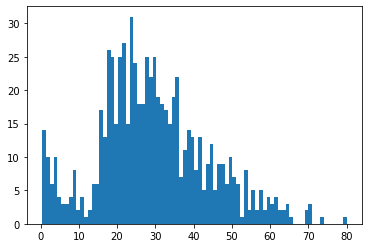

In [21]:
plt.hist(titanic_train.Age, bins = 80)
titanic_train.Age.describe()

count    332.000000
mean      30.272590
std       14.181209
min        0.170000
25%       21.000000
50%       27.000000
75%       39.000000
max       76.000000
Name: Age, dtype: float64

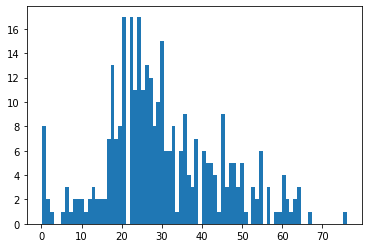

In [22]:
plt.hist(titanic_test.Age, bins = 80)
titanic_test.Age.describe()

<AxesSubplot:xlabel='Survived', ylabel='Age'>

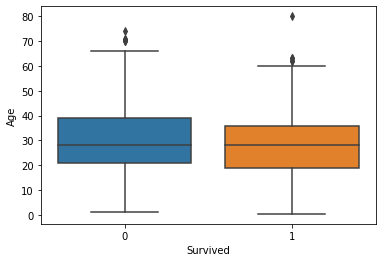

In [23]:
sns.boxplot(x="Survived", y="Age", data=titanic_train)


The majority of passengers may be travelling on their own without a spouse, sibling, children of parents on board. However, passengers with 1 or 2 siblings/spouse appears to have survived; the percentages is in the range of 46% to 54%. Parents or individuals with one, two or three parents were less likely to perished - the percentages ranges between 50% and 60%.

In [24]:
titanic_train.groupby(["SibSp"]).count()["PassengerId"]/titanic_train.shape[0]


SibSp
0    0.682379
1    0.234568
2    0.031425
3    0.017957
4    0.020202
5    0.005612
8    0.007856
Name: PassengerId, dtype: float64

In [25]:
temp =  titanic_train.groupby(["SibSp","Survived"]).count()["PassengerId"]
temp = temp.groupby(level=0).apply(lambda x:  x / float(x.sum()))    
temp.unstack()

Survived,0,1
SibSp,,
0,0.654605,0.345395
1,0.464115,0.535885
2,0.535714,0.464286
3,0.750000,0.250000
4,0.833333,0.166667
5,1.000000,NaN
8,1.000000,NaN


count    891.000000
mean       0.523008
std        1.102743
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        8.000000
Name: SibSp, dtype: float64

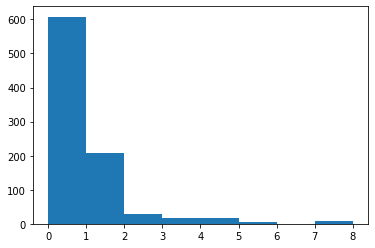

In [26]:
plt.hist(titanic_train.SibSp, bins = 8)
titanic_train.SibSp.describe()

In [27]:
titanic_train.groupby(["Parch"]).count()["PassengerId"]/titanic_train.shape[0]


Parch
0    0.760943
1    0.132435
2    0.089787
3    0.005612
4    0.004489
5    0.005612
6    0.001122
Name: PassengerId, dtype: float64

In [28]:
temp =  titanic_train.groupby(["Parch","Survived"]).count()["PassengerId"]
temp = temp.groupby(level=0).apply(lambda x:  x / float(x.sum()))    
temp.unstack()

Survived,0,1
Parch,,
0,0.656342,0.343658
1,0.449153,0.550847
2,0.500000,0.500000
3,0.400000,0.600000
4,1.000000,NaN
5,0.800000,0.200000
6,1.000000,NaN


count    891.000000
mean       0.381594
std        0.806057
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        6.000000
Name: Parch, dtype: float64

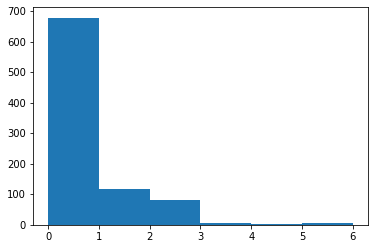

In [29]:
plt.hist(titanic_train.Parch, bins = 6)
titanic_train.Parch.describe()

We decided to add both fields _Parch_ and _SibSp_ together as a familly. The mean and median age appears to be quite close between the passengers who have survived and perished. For smaller families the spread appears to be smaller than for larger families.  

The highest percentages of surviving the accident suggests that passengers in first and second class with no other familly members. These percentages are loweer than 30%.

In [30]:
titanic_train["familly"] = titanic_train.SibSp + titanic_train.Parch
temp =  titanic_train.groupby(["familly","Survived"]).agg([np.median, np.mean, np.std])["Age"]
temp.unstack()

median             mean                   std           
Survived      0     1          0          1          0          1
familly                                                          
0          29.0  30.0  32.414234  31.811538  13.334968  11.970452
1          30.0  29.0  32.126984  30.781842  11.599836  14.916443
2          30.5  22.0  31.500000  21.911887  13.776141  17.363697
3          25.0  14.0  22.833333  16.972381  11.196726  15.054360
4          12.5  21.0  17.000000  31.000000  15.528775  19.974984
5           9.0  24.0  17.578947  23.666667  18.637822   0.577350
6           9.0  11.0  14.875000  15.750000  15.169871  16.070159
7          12.5   NaN  15.666667        NaN  14.361987        NaN
10          NaN   NaN        NaN        NaN        NaN        NaN

count    891.000000
mean       0.904602
std        1.613459
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max       10.000000
Name: familly, dtype: float64

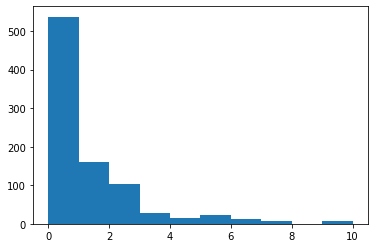

In [31]:
plt.hist(titanic_train.familly, bins = 10)
titanic_train.familly.describe()

In [32]:
temp =  titanic_train.groupby(["familly","Pclass","Survived"]).count()["PassengerId"]
temp = temp.groupby(level=1).apply(lambda x:  x / float(x.sum()))      
temp.unstack()                                                    

Survived               0         1
familly Pclass                    
0       1       0.236111  0.268519
        2       0.369565  0.195652
        3       0.519348  0.140530
1       1       0.087963  0.236111
        2       0.086957  0.097826
        3       0.075356  0.040733
2       1       0.027778  0.083333
        2       0.054348  0.114130
        3       0.054990  0.040733
3       1       0.009259  0.023148
        2       0.016304  0.054348
        3       0.006110  0.012220
4       1            NaN  0.009259
        2            NaN  0.005435
        3       0.024440       NaN
5       1       0.009259  0.009259
        2            NaN  0.005435
        3       0.034623       NaN
6       3       0.016293  0.008147
7       3       0.012220       NaN
10      3       0.014257       NaN

## Futher analysis and discussions
The data in their current states suggests that the distribution for the field _Survived_ is likely to be binomial. It has a lowest occurrences of surviving, which is a shocking statistic.

The passenger class has more occurrences of third classes. However, First and second class female passengers were more likely to survive the accident. First class male passengers had the also the highest survival rate. The Age is skewed to the left; some age may be unknown. It appears (see below) the younger passengers may have been traveling with other members of a family and perhaps reduced their survival rates; the largest familly appears to be travelling in third class. Most occurrences were families made of 0, 1, or 3 family members. 

This analysis suggests that perhaps the passenger class and the gender may have contributed to a higher survival rate. However, the familly size may have contributed to survived too. The classifiers will need to identify the lack of other patterns that may have contributed to survive the accident. It is likely to be quite challenging as no linear relationships or grouping may be present in the data.



array([[<AxesSubplot:xlabel='Survived', ylabel='Survived'>,
        <AxesSubplot:xlabel='Pclass', ylabel='Survived'>,
        <AxesSubplot:xlabel='Age', ylabel='Survived'>,
        <AxesSubplot:xlabel='familly', ylabel='Survived'>],
       [<AxesSubplot:xlabel='Survived', ylabel='Pclass'>,
        <AxesSubplot:xlabel='Pclass', ylabel='Pclass'>,
        <AxesSubplot:xlabel='Age', ylabel='Pclass'>,
        <AxesSubplot:xlabel='familly', ylabel='Pclass'>],
       [<AxesSubplot:xlabel='Survived', ylabel='Age'>,
        <AxesSubplot:xlabel='Pclass', ylabel='Age'>,
        <AxesSubplot:xlabel='Age', ylabel='Age'>,
        <AxesSubplot:xlabel='familly', ylabel='Age'>],
       [<AxesSubplot:xlabel='Survived', ylabel='familly'>,
        <AxesSubplot:xlabel='Pclass', ylabel='familly'>,
        <AxesSubplot:xlabel='Age', ylabel='familly'>,
        <AxesSubplot:xlabel='familly', ylabel='familly'>]], dtype=object)

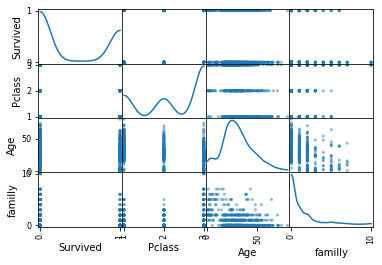

In [33]:
columns = ["Survived","Pclass","Age", "familly"]
titanic_train = titanic_train[columns]
pd.plotting.scatter_matrix(titanic_train, diagonal='kde')

The percentages suggests passenger class and gender may be the factor that may lead to survival. 

# Data preparation for classification

## Integer to float
We upload the data for a cleaning and display the columns with their data types to float on both datasets.

In [34]:
titanic_train = pd.read_csv(train_data_path)
titanic_train.dtypes



PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [35]:
titanic_test = pd.read_csv(test_data_path)
titanic_test.dtypes



PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [36]:
titanic_train["PassengerId"] = titanic_train["PassengerId"].astype(float)
titanic_train["SibSp"] = titanic_train["SibSp"].astype(float)
titanic_train["Parch"] = titanic_train["Parch"].astype(float)
titanic_train["Survived"] = titanic_train["Survived"].astype(float)
titanic_train["Pclass"] = titanic_train["Pclass"].astype(float)
titanic_train.dtypes

PassengerId    float64
Survived       float64
Pclass         float64
Name            object
Sex             object
Age            float64
SibSp          float64
Parch          float64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [37]:
titanic_test["PassengerId"] = titanic_test["PassengerId"].astype(float)
titanic_test["SibSp"] = titanic_test["SibSp"].astype(float)
titanic_test["Parch"] = titanic_test["Parch"].astype(float)
titanic_test["Pclass"] = titanic_test["Pclass"].astype(float)
titanic_test.dtypes

PassengerId    float64
Pclass         float64
Name            object
Sex             object
Age            float64
SibSp          float64
Parch          float64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

## Null values 

We remove all the nulls values from some of the columns; i.e., PassengerId, Fare, SibSp, Parch, and Embarked. Some fares were unknown, but all passengers ID was set to a unique number. 

In [39]:
titanic_train.PassengerId.isnull().sum()


0

In [40]:
titanic_test.PassengerId.isnull().sum()


0

In [42]:
titanic_train.Fare.isnull().sum()


0

In [41]:
titanic_test.Fare.isnull().sum()

1

In [76]:
titanic_train.Parch.isnull().sum()

0

In [78]:
titanic_test.SibSp.isnull().sum()

0

In [76]:
titanic_train.SibSp.isnull().sum()

0

In [43]:
titanic_test.loc[titanic_test["Fare"].isnull(),"Fare"] = -1.0
titanic_test.Fare.isnull().sum()

0

Quite a few passengers' age is unknown. We will try to input a value based using the sibling/spouse and parchment statistical values to infer some replacement values. 

We discover that the median age of parents is approximately between 22 and 23 years old. The mean and median of passengers travelling on their own - with no children, spouse, no sibling - were much older.

In [44]:
titanic_train.Age.isnull().sum()

177

In [79]:
median_parents  = titanic_train.loc[titanic_train["Age"].notnull() & titanic_train["Parch"] > 0, "Age"].median()
mean_parents    = titanic_train.loc[titanic_train["Age"].notnull() & titanic_train["Parch"] > 0, "Age"].mean()
print("median age ", median_parents, " mean age ", mean_parents)

median age  22.0  mean age  23.006062176165802


In [80]:
filter_rows    = (titanic_train["Age"].notnull()) & (titanic_train["Parch"] < 1.0) & (titanic_train["SibSp"] < 1.0)
median_single  = titanic_train.loc[filter_rows, "Age"].median()
mean_single    = titanic_train.loc[filter_rows, "Age"].mean()
print("median age ", median_single, " mean age ", mean_single)

titanic_train.loc[filter_rows, :]

median age  29.5  mean age  32.22029702970297


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
2,3.0,1.0,3.0,"Heikkinen, Miss. Laina",female,26.0,0.0,0.0,STON/O2. 3101282,7.9250,NaN,S
4,5.0,0.0,3.0,"Allen, Mr. William Henry",male,35.0,0.0,0.0,373450,8.0500,NaN,S
6,7.0,0.0,1.0,"McCarthy, Mr. Timothy J",male,54.0,0.0,0.0,17463,51.8625,E46,S
11,12.0,1.0,1.0,"Bonnell, Miss. Elizabeth",female,58.0,0.0,0.0,113783,26.5500,C103,S
12,13.0,0.0,3.0,"Saundercock, Mr. William Henry",male,20.0,0.0,0.0,A/5. 2151,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
884,885.0,0.0,3.0,"Sutehall, Mr. Henry Jr",male,25.0,0.0,0.0,SOTON/OQ 392076,7.0500,NaN,S
886,887.0,0.0,2.0,"Montvila, Rev. Juozas",male,27.0,0.0,0.0,211536,13.0000,NaN,S
887,888.0,1.0,1.0,"Graham, Miss. Margaret Edith",female,19.0,0.0,0.0,112053,30.0000,B42,S
889,890.0,1.0,1.0,"Behr, Mr. Karl Howell",male,26.0,0.0,0.0,111369,30.0000,C148,C


In [ ]:
titanic_train.loc[titanic_train["Age"].isnull(),"Age"] = -1.0
titanic_train.Age.isnull().sum()

In [ ]:
titanic_test.loc[titanic_test["Age"].isnull(),"Age"] = -1.0
titanic_test.Age.isnull().sum()

We remove any NAs from the embarked column

In [ ]:
print("Training : " , titanic_train.Embarked.unique())
print("Testing  : " , titanic_test.Embarked.unique())

In [ ]:
titanic_train.loc[titanic_train['Embarked'].isna(),'Embarked'] = 'U'

In [ ]:
titanic_test.loc[titanic_test['Embarked'].isna(),'Embarked'] = 'U'


In [ ]:
print("Training : " , titanic_train.Embarked.unique())
print("Testing  : " , titanic_test.Embarked.unique())

In [ ]:
print("Training : " , titanic_train.Sex.unique())
print("Testing  : " , titanic_test.Sex.unique())

In [ ]:
print("Training : " , titanic_train.Pclass.unique())
print("Testing  : " , titanic_test.Pclass.unique())

## PClass and Fare

We explore first if there is correalation between the passenger class and prices. We also explore the skewness of the fares. So we normalise the fare to move more the values towards the mean. We hope it will help the decision trees and random forrest classification.

In [ ]:
temp =  titanic_train.groupby(["Pclass","Fare","Survived"]).count()["PassengerId"]
temp = temp.groupby(level=1).apply(lambda x:100 * x / float(x.sum()))                               
temp

In [ ]:
plt.hist(titanic_train.Fare, bins=200)

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
plt.suptitle('')
titanic_train.boxplot(column=['Fare'], by='Pclass', ax=ax)

In [ ]:
titanic_train.groupby("Pclass").describe()["Fare"]

In [ ]:
plt.scatter(titanic_train.Age,np.log(titanic_train.Fare))
    

In [ ]:
mean_fare = titanic_train.Fare.mean()
std_fare = titanic_train.Fare.std()
titanic_train.loc[:,"Fare"] = (titanic_train.Fare - mean_fare)/std_fare
titanic_train.Fare.describe()


In [ ]:
plt.hist(titanic_train.Fare, bins = 100)

In [ ]:
mean_fare = titanic_test.Fare.mean()
std_fare = titanic_test.Fare.std()
titanic_test.loc[:,"Fare"] = (titanic_test.Fare - mean_fare)/std_fare
titanic_test.Fare.describe()


In [ ]:
plt.hist(titanic_test.Fare, bins = 100)

In [ ]:
titanic_train.dtypes

## Age
We normalise the age to bring more the data towards the mean.

In [ ]:
plt.hist(titanic_train.Age, bins = 100)

In [ ]:
mean_age = titanic_train.Age.mean()
std_age = titanic_train.Age.std()
titanic_train.loc[:,"Age"] = (titanic_train.Age - mean_age)/std_age
titanic_train.Age.describe()


In [ ]:
plt.hist(titanic_train.Age, bins = 100)

In [ ]:
mean_age = titanic_test.Age.mean()
std_age = titanic_test.Age.std()
titanic_test.loc[:,"Age"] = (titanic_test.Age - mean_age)/std_age
titanic_train.Age.describe()

## Embarked

Embarked has three values "S", 'C', 'Q' and "U".  

In [ ]:
titanic_train.groupby("Embarked").count()["PassengerId"]

In [ ]:
titanic_test.groupby("Embarked").count()["PassengerId"]

In [ ]:
titanic_train["Embarked"].replace({"U":0, "S":1, "C":2, "Q":3}, inplace = True)
titanic_train["Embarked"] = titanic_train["Embarked"].astype(float)
titanic_train.groupby("Embarked").count()["PassengerId"]



In [ ]:
titanic_test["Embarked"].replace({"U":0, "S":1, "C":2, "Q":3}, inplace = True)
titanic_test["Embarked"] = titanic_test["Embarked"].astype(float)
titanic_test.groupby("Embarked").count()["PassengerId"]

## Gender 
We replace the male with 1 and female with the value 2.

In [ ]:
print("Training : ", titanic_train['Sex'].unique())
print("Test     : ", titanic_train['Sex'].unique())



In [ ]:
titanic_train["Sex"].replace({"male":1.0, "female":2.0}, inplace = True)
titanic_train["Sex"] = titanic_train["Sex"].astype(float)
titanic_train.groupby("Sex").count()["PassengerId"]

In [ ]:
titanic_test["Sex"].replace({"male":1.0, "female":2.0}, inplace = True)
titanic_test["Sex"] = titanic_test["Sex"].astype(float)
titanic_test.groupby("Sex").count()["PassengerId"]


## Sibling and parentage

We sum the siblin and parentage. 

In [ ]:
titanic_train["SibSp"].unique()


In [ ]:
titanic_train["Parch"].unique()

In [ ]:
titanic_train["fam_members"] = titanic_train["SibSp"] + titanic_train["Parch"]
titanic_train["fam_members"].describe()

In [ ]:
titanic_test["fam_members"] = titanic_test["SibSp"] + titanic_test["Parch"]
titanic_test["fam_members"].describe()

In [ ]:
titanic_test["fam_members"] = titanic_test["SibSp"] + titanic_test["Parch"]
titanic_test["fam_members"].describe()

In [ ]:
titanic_train.dtypes

In [ ]:
titanic_test.dtypes

## Columns to drop 
We drop some columns; they may have too many unknown values. Some of them may be dependent statistical variables. We assume the price of a ticket may be dependent of the fare.  

In [ ]:
titanic_train.drop("Name", axis = 1, inplace = True)
titanic_train.drop("Ticket", axis = 1, inplace = True)
titanic_train.drop("Cabin", axis = 1, inplace = True)
titanic_train.drop("SibSp", axis = 1, inplace = True)
titanic_train.drop("Parch", axis = 1, inplace = True)

titanic_train.dtypes

In [ ]:
titanic_test.drop("Name", axis = 1, inplace = True)
titanic_test.drop("Ticket", axis = 1, inplace = True)
titanic_test.drop("Cabin", axis = 1, inplace = True)
titanic_test.drop("SibSp", axis = 1, inplace = True)
titanic_test.drop("Parch", axis = 1, inplace = True)

titanic_test.dtypes

## Preparation Cross validation 
We show how the transformation have affected both datasets

In [ ]:
titanic_train.dtypes

In [ ]:
titanic_train.shape

In [ ]:
titanic_test.dtypes

In [ ]:
titanic_test.shape

In [ ]:
temp =  titanic_train.groupby(["Survived","Pclass","Sex","fam_members"]).count()["PassengerId"]
temp = temp.groupby(level=1).apply(lambda x:  x / float(x.sum()))  
temp.reset_index()
temp.head(100)

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
plt.suptitle('')
titanic_train.boxplot(column=['fam_members'], by="Survived", ax=ax)

# Decision Trees and Random Forrest


## Preparation Cross validation 

We split the training datasets into a training and valication dataset. We use stratified shuffle for this purpose. 

In [ ]:
x_cols = ["Fare","Pclass","Sex","Embarked","fam_members", "Age"]
y_col = 'Survived'
X = titanic_train.copy(deep = True)
X = X[x_cols]
#X = X.apply(pd.to_numeric)
y = titanic_train[y_col].apply(pd.to_numeric)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
for train_index, test_valid_index in split.split(X, y):
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_valid  = X.iloc[test_valid_index]
    y_valid  = y.iloc[test_valid_index]

# we see our training set follows the same distribution
print(y_train.value_counts(normalize=True), '\n\n')

# we see our test set follows the same distribution
print(y_valid.value_counts(normalize=True))

In [ ]:
x_cols = ["Fare","Pclass","Sex","Embarked","fam_members", "Age"]
X = titanic_test.copy(deep = True)
X_test = X[x_cols]
X_test.columns

## Decision Tree classifier

We explore the maximum depths hyper parameter using a deterministic and incremental search. Then we applied the most efficient parametrisation. We chose a low maximum depth, as the model may be overfitting.

In [ ]:

depths = range(3, 200)
for depth in depths:
    clf = DecisionTreeClassifier(max_depth = depth, criterion ="entropy")

    # Train Decision Tree Classifer
    clf = clf.fit(X_train,y_train)
    train_score = clf.score(X_train,y_train)
    valid_score = clf.score(X_valid,y_valid)
    print("- depth : ", depth, " - train score : ", train_score, " -  valid score : ", valid_score)
   


In [ ]:
clf = DecisionTreeClassifier(max_depth = 5, criterion ="gini")

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)
train_score = clf.score(X_train,y_train)
valid_score = clf.score(X_valid,y_valid)
print("- depth : ", 5, " - train score : ", train_score, " -  valid score : ", valid_score)

The next step is to explore the number of maximum features used.  We chose two. 

In [ ]:
features = range(1, X_train.shape[1])
for max_feature in features:
    clf = DecisionTreeClassifier(max_depth = 5, criterion ="entropy", max_features = max_feature)
    # Train Decision Tree Classifer
    clf = clf.fit(X_train,y_train)
    train_score = clf.score(X_train,y_train)
    valid_score = clf.score(X_valid,y_valid)
    print("- max feature: ", max_feature, " - train score : ", train_score, " -  valid score : ", valid_score)
   

In [ ]:
clf = DecisionTreeClassifier(max_depth = 5, criterion ="gini", max_features = 2)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)
train_score = clf.score(X_train,y_train)
valid_score = clf.score(X_valid,y_valid)
print("- depth : ", 5, " - train score : ", train_score, " -  valid score : ", valid_score)

In [ ]:
importances = clf.feature_importances_
importances =  pd.DataFrame(x_cols, importances)
importances

Several runs of applying decision tree has suggested the gender, passenger class, age, Fare and number of familly numbers may influencd the most the classification. Therefore, we decided to reduce the dataset to the following columns; Sex, Pclass, fam_members, and Age. 

### Which passengers were misclassified 

In [ ]:
y_pred  = clf.predict(X_valid)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_valid, y_pred)

Overall, the number of survivors misclassified were greater than misclassifiee  passengers who  perished. The next step is to identify those passengers to attempt to find the source of the misclassification.

In [ ]:
errors_pd = X_valid.copy(deep=True)
errors_pd["Y_true"] = y_valid
errors_pd["Y_pred"] = y_pred
errors_pd = errors_pd.loc[errors_pd["Y_true"] !=  errors_pd["Y_pred"],]
errors_pd

In [ ]:
errors_pd.describe()

In [ ]:
plt.scatter(errors_pd["Fare"], errors_pd["Pclass"])

In [ ]:
errors_pd.loc[errors_pd["Pclass"] == 1.0]

In [ ]:
errors_pd.loc[errors_pd["Pclass"] == 2.0]

In [ ]:
errors_pd.loc[errors_pd["Pclass"] == 3.0]

The passenger class  and being  male can lead  to errors. However, the number of female passengers increases as the class lower.

## Classification using test datasets

In [ ]:
y_pred = clf.predict(X_test)
decision_tree_pred = pd.DataFrame({"PassengerId": titanic_test.PassengerId,
                                   "Survived": y_pred})
decision_tree_pred

## Decision Trees with reduced dataset

We explore whether a reduction of statistical variables may be beneficial to the classification. We have yet to find a better result. So Decision tree may have found its limit. 

In [ ]:
x_cols = ["Pclass","Sex", "fam_members"]
y_col = 'Survived'
X = titanic_train.copy(deep = True)
X = X[x_cols]
#X = X.apply(pd.to_numeric)
y = titanic_train[y_col].apply(pd.to_numeric)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
for train_index, test_valid_index in split.split(X, y):
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_valid  = X.iloc[test_valid_index]
    y_valid  = y.iloc[test_valid_index]

# we see our training set follows the same distribution
print(y_train.value_counts(normalize=True), '\n\n')

# we see our test set follows the same distribution
print(y_valid.value_counts(normalize=True))

In [ ]:
x_cols = ["Pclass","Sex", "fam_members"]
X = titanic_test.copy(deep = True)
X_test = X[x_cols]
X_test.columns

In [ ]:

clf = DecisionTreeClassifier(max_depth = 5, criterion ="entropy", max_features = 3)
    # Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)
train_score = clf.score(X_train,y_train)
valid_score = clf.score(X_valid,y_valid)
print("- depth : ", 5, "- max feature: ", 3, " - train score : ", train_score, " -  valid score : ", valid_score)
   

### Which passengers were misclassified ?

In [ ]:
y_pred  = clf.predict(X_valid)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_valid, y_pred)

Overall, the number of survivors misclassified were greater than misclassifiee  passengers who  perished. The next step is to identify those passengers to attempt to find the source of the misclassification. The reduced statistical variables degraded the accuracy

In [ ]:
errors_pd = X_valid.copy(deep=True)
errors_pd["Y_true"] = y_valid
errors_pd["Y_pred"] = y_pred
errors_pd = errors_pd.loc[errors_pd["Y_true"] !=  errors_pd["Y_pred"],]
errors_pd

In [ ]:
errors_pd.describe()

In [ ]:
errors_pd.groupby(["Pclass","fam_members","Sex","Y_true"]).count()["Y_pred"]

__REWRITE__
The passenger class  and being  male can lead  to errors. However, the number of female passengers increases as the class lower.

In [ ]:
y_pred = clf.predict(X_test)
decision_tree_red_dat_pred = pd.DataFrame({"PassengerId": titanic_test.PassengerId,
                                   "Survived": y_pred})
decision_tree_red_dat_pred

# Random Forrest

## Preparation Cross validation 

We split the training datasets into a training and valication dataset. We use stratified shuffle for this purpose. 

In [ ]:
x_cols = ["Fare","Pclass","Sex","Embarked","fam_members", "Age"]
y_col = 'Survived'
X = titanic_train.copy(deep = True)
X = X[x_cols]
#X = X.apply(pd.to_numeric)
y = titanic_train[y_col].apply(pd.to_numeric)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
for train_index, test_valid_index in split.split(X, y):
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_valid  = X.iloc[test_valid_index]
    y_valid  = y.iloc[test_valid_index]



# we see our test set follows the same distribution
print(y_valid.value_counts(normalize=True))

In [ ]:
x_cols = ["Fare","Pclass","Sex","Embarked","fam_members", "Age"]
X = titanic_test.copy(deep = True)
X_test = X[x_cols]
X_test.columns

## Model fitting and classification

Random Forrest overfits to the training dataset. 

In [ ]:
from sklearn.ensemble import RandomForestClassifier

n_estimators = range(1,40)
max_depths   = range(1,10)

for est in n_estimators:
    for depth in max_depths:
        rf = RandomForestClassifier(n_estimators = est, max_depth = depth, random_state = 42)
        rf.fit(X_train, y_train)
        train_score = rf.score(X_train, y_train)
        test_score  = rf.score(X_valid, y_valid)
        print(" - estimators : ", est, 
              " - max depths : ", depth, 
              " - train score : ", train_score,
              " - valid score : ", valid_score)
        
        


In [ ]:
rf = RandomForestClassifier(n_estimators = 39, max_depth=9, random_state = 42)
rf.fit(X_train, y_train)


In [ ]:
rf.score(X_train, y_train)

In [ ]:
rf.score(X_valid, y_valid)

In [ ]:
importances = rf.feature_importances_
importances =  pd.DataFrame(x_cols, importances)
importances


We found the classes of importances are Fares, Sex, and Age.  

### Which passengers were misclassified ?

In [ ]:
y_pred  = rf.predict(X_valid)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_valid, y_pred)

Overall, the number of survivors misclassified were greater than misclassified  passengers who  perished. 

We explore further these erroneous predictions.

In [ ]:
errors_pd = X_valid.copy(deep=True)
errors_pd["Y_true"] = y_valid
errors_pd["Y_pred"] = y_pred
errors_pd = errors_pd.loc[errors_pd["Y_true"] !=  errors_pd["Y_pred"],]
errors_pd

In [ ]:
errors_pd.describe()

In [ ]:
plt.scatter(errors_pd["Fare"], errors_pd["Pclass"])

In [ ]:
errors_pd.groupby(["Pclass","fam_members","Sex","Y_true"]).count()["Y_pred"]

The passenger class  and being  male can lead  to errors. However, the number of female passengers increases as the class lower. These two  observations remains valid for a Random Forrest Classifier. Nonetheless, we can suggest the accuracy has increased for the second class passengers.

In [ ]:
y_pred = rf.predict(X_test)
random_pred = pd.DataFrame({"PassengerId": titanic_test.PassengerId,
                                   "Survived": y_pred})
random_pred

## Limited datasets

We split the training datasets into a training and valication dataset. We use stratified shuffle for this purpose. 

In [ ]:
x_cols = ["Pclass","Sex", "fam_members"]
y_col = 'Survived'
X = titanic_train.copy(deep = True)
X = X[x_cols]
#X = X.apply(pd.to_numeric)
y = titanic_train[y_col].apply(pd.to_numeric)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
for train_index, test_valid_index in split.split(X, y):
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_valid  = X.iloc[test_valid_index]
    y_valid  = y.iloc[test_valid_index]

# we see our training set follows the same distribution
print(y_train.value_counts(normalize=True), '\n\n')

# we see our test set follows the same distribution
print(y_valid.value_counts(normalize=True))

In [ ]:
x_cols = ["Pclass","Sex", "fam_members"]
X = titanic_test.copy(deep = True)
X_test = X[x_cols]
X_test.columns

In [ ]:
rf = RandomForestClassifier(n_estimators = 39, max_depth=9, random_state = 42)
rf.fit(X_train, y_train)


In [ ]:
rf.score(X_train, y_train)

In [ ]:
rf.score(X_valid, y_valid)

### Which passengers were misclassified 

In [ ]:
y_pred  = rf.predict(X_valid)

In [ ]:

from sklearn.metrics import confusion_matrix
confusion_matrix(y_valid, y_pred)

Overall, the number of survivors misclassified were greater than misclassified passengers who perished. The next step is to identify those passengers to attempt to find the source of the misclassifcation.

In [ ]:
errors_pd = X_valid.copy(deep=True)
errors_pd["Y_true"] = y_valid
errors_pd["Y_pred"] = y_pred
errors_pd = errors_pd.loc[errors_pd["Y_true"] !=  errors_pd["Y_pred"],]
errors_pd

In [ ]:
errors_pd.describe()

In [ ]:
errors_pd.loc[errors_pd["Pclass"] == 1.0]

In [ ]:
errors_pd.loc[errors_pd["Pclass"] == 2.0]

In [ ]:
errors_pd.loc[errors_pd["Pclass"] == 3.0]

The passenger class  and being  male can lead  to errors. However, the number of female passengers increases as the class lower.

# Logistic regression

We explore apply a logistic regression. It is may be the most suitable as we have two classes; survived  or not.

## Split  data sets for cross validation

In [ ]:
x_cols =["Fare","Pclass","Sex","Embarked","fam_members", "Age"]
y_col = 'Survived'
X = titanic_train.copy(deep = True)
X = X[x_cols]
#X = X.apply(pd.to_numeric)
y = titanic_train[y_col].apply(pd.to_numeric)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
for train_index, test_valid_index in split.split(X, y):
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_valid  = X.iloc[test_valid_index]
    y_valid  = y.iloc[test_valid_index]

# we see our training set follows the same distribution
print(y_train.value_counts(normalize=True), '\n\n')

# we see our test set follows the same distribution
print(y_valid.value_counts(normalize=True))

In [ ]:
x_cols = ["Fare","Pclass","Sex","Embarked","fam_members", "Age"]
X = titanic_test.copy(deep = True)
X_test = X[x_cols]
X_test.columns

## Model fitting

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
classifier = LogisticRegression(random_state = 0, C = 1.0)
classifier.fit(X_train, y_train)
classifier.coef_

In [ ]:
classifier.score(X_train, y_train)

In [ ]:
classifier.score(X_valid, y_valid)

### Which passengers were misclassified ?

In [ ]:
y_pred= classifier.predict(X_valid)

In [ ]:

from sklearn.metrics import confusion_matrix
confusion_matrix(y_valid, y_pred)

Overall, the number of survivors misclassified were greater than misclassified passengers who perished. The next step is to identify those passengers to attempt to find the source of the misclassifcation.

In [ ]:
errors_pd = X_valid.copy(deep=True)
errors_pd["Y_true"] = y_valid
errors_pd["Y_pred"] = y_pred
errors_pd = errors_pd.loc[errors_pd["Y_true"] !=  errors_pd["Y_pred"],]
errors_pd

In [ ]:
errors_pd.describe()

In [ ]:
errors_pd.groupby(["Pclass","fam_members","Sex","Y_true"]).count()["Y_pred"]

The passenger class  and being  male can lead  to errors. However, the number of female passengers increases as the class lower.

In [ ]:
y_pred = classifier.predict(X_test)
log_reg_pred = pd.DataFrame({"PassengerId": titanic_test.PassengerId,
                                   "Survived": y_pred})
log_reg_pred

# K-Nearest-neighbourn

We explore whether a reduction of statistical variables may be beneficial to the classification. We have yet to find a better result. So Decision tree may have found its limit. 

In [ ]:
x_cols =["Fare","Pclass","Sex","Embarked","fam_members", "Age"]
y_col = 'Survived'
X = titanic_train.copy(deep = True)
X = X[x_cols]
#X = X.apply(pd.to_numeric)
y = titanic_train[y_col].apply(pd.to_numeric)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
for train_index, test_valid_index in split.split(X, y):
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_valid  = X.iloc[test_valid_index]
    y_valid  = y.iloc[test_valid_index]

# we see our training set follows the same distribution
print(y_train.value_counts(normalize=True), '\n\n')

# we see our test set follows the same distribution
print(y_valid.value_counts(normalize=True))

In [ ]:
x_cols = ["Fare","Pclass","Sex","Embarked","fam_members", "Age"]
X = titanic_test.copy(deep = True)
X_test = X[x_cols]
X_test.columns

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 3, algorithm="auto", weights = "distance")
knn.fit(X_train,y_train)

In [ ]:
knn.score(X_train, y_train)

In [ ]:
knn.score(X_valid, y_valid)

In [ ]:
neighbors = range(2, 100)
for neighbor in neighbors:
    knn = KNeighborsClassifier(n_neighbors = 3, algorithm="auto", weights = "distance")
    knn.fit(X_train,y_train)
    train_score = knn.score(X_train, y_train)
    valid_score = knn.score(X_valid, y_valid)
    print(" - n neighbor : ", neighbor , " - train score : ", train_score, " - valid score : ", valid_score)

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 99, algorithm="auto", weights = "distance")
knn.fit(X_train, y_train)

### Which passengers were misclassified ?

In [ ]:
y_pred  = knn.predict(X_valid)

In [ ]:

from sklearn.metrics import confusion_matrix
confusion_matrix(y_valid, y_pred)

Overall, the number of survivors misclassified were greater than misclassified passengers who perished. The next step is to identify those passengers to attempt to find the source of the misclassifcation.

In [ ]:
errors_pd = X_valid.copy(deep=True)
errors_pd["Y_true"] = y_valid
errors_pd["Y_pred"] = y_pred
errors_pd = errors_pd.loc[errors_pd["Y_true"] !=  errors_pd["Y_pred"],]
errors_pd

In [ ]:
errors_pd.describe()

In [ ]:
errors_pd.groupby(["Pclass","fam_members","Sex","Y_true"]).count()["Y_pred"]

The passenger class  and being  male can lead  to errors. However, the number of female passengers increases as the class lower.

In [ ]:
y_pred = knn.predict(X_test)
knn_pred = pd.DataFrame({"PassengerId": titanic_test.PassengerId,
                                   "Survived": y_pred})
knn_pred

## K-NN with reduced dataset

We explore whether a reduction of statistical variables may be beneficial to the classification. We have yet to find a better result. So Decision tree may have found its limit. 

In [ ]:
x_cols = ["Pclass","Sex", "Age"]
y_col = 'Survived'
X = titanic_train.copy(deep = True)
X = X[x_cols]
#X = X.apply(pd.to_numeric)
y = titanic_train[y_col].apply(pd.to_numeric)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
for train_index, test_valid_index in split.split(X, y):
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_valid  = X.iloc[test_valid_index]
    y_valid  = y.iloc[test_valid_index]

# we see our training set follows the same distribution
print(y_train.value_counts(normalize=True), '\n\n')

# we see our test set follows the same distribution
print(y_valid.value_counts(normalize=True))

In [ ]:
x_cols = ["Pclass","Sex", "Age"]
X = titanic_test.copy(deep = True)
X_test = X[x_cols]
X_test.columns

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 3, algorithm="auto", weights = "distance")
knn.fit(X_train,y_train)

In [ ]:
knn.score(X_train, y_train)

In [ ]:
knn.score(X_valid, y_valid)

In [ ]:
y_pred = knn.predict(X_test)
knn_red_dat_pred = pd.DataFrame({"PassengerId": titanic_test.PassengerId,
                                   "Survived": y_pred})
knn_red_dat_pred

# Prepare data for Neural-AI

In [ ]:
titanic_train = pd.read_csv(train_data_path)
titanic_train.columns

In [ ]:
titanic_test = pd.read_csv(test_data_path)
titanic_test.columns

## Select reduce columns 

In [ ]:
titanic_train.dtypes

In [ ]:
titanic_test.dtypes

I propose to keep Pclass,Sex, Age, SibSP,Parch,Ticket, Fare,Cabin, Embarked, Survived

In [ ]:
columns_to_keep = ['PassengerId','Pclass', 'Sex',  'Age',  'SibSp', 'Parch','Ticket', 'Fare','Cabin', 'Embarked', 'Survived']
titanic_train = titanic_train.loc[:,columns_to_keep]
titanic_train.head()

In [ ]:
columns_to_keep = ['PassengerId','Pclass', 'Sex',  'Age',  'SibSp', 'Parch','Ticket', 'Fare','Cabin', 'Embarked']
titanic_test = titanic_test.loc[:,columns_to_keep]
titanic_test.head()

# Passengers ID
Transforms to float

In [ ]:

titanic_train["PassengerId"] = titanic_train["PassengerId"].astype(float)
titanic_test["PassengerId"]  = titanic_test["PassengerId"].astype(float)

# Number of sibling

In [ ]:
print(titanic_train["SibSp"].describe())
plt.hist(titanic_train["SibSp"])

In [ ]:
print(titanic_test["SibSp"].describe())
plt.hist(titanic_test["SibSp"])

In [ ]:
def categorise_siblings(data):
    cut_labels_9 = ['sib_0','sib_1','sib_2','sib_3', 
                    'sib_4','sib_5','sib_6','sib_7', 'sib_8']
    cut_bins = [0,1,2,3,4,5,6,7,8,9]
    data['Sib_cat'] = pd.cut(data['SibSp'], 
                             bins=cut_bins, 
                             labels=cut_labels_9)
    
    data['Sib_cat'] = data.Sib_cat.astype(str)
    data.loc[data["Sib_cat"] == 'nan', "Sib_cat"] = "Sib_Unknown"
    
    return data

def transform_sibling_cat(data):
    factors = data['Sib_cat'].unique()
    gender_columns = pd.get_dummies(data['Sib_cat'])
    columns = range(0,len(factors))
    for column in columns:
        data[factors[column]] = gender_columns.loc[:, factors[column]].astype(float)
        
    return data

In [ ]:
titanic_train = categorise_siblings(titanic_train)
titanic_train = transform_sibling_cat(titanic_train)
titanic_train = titanic_train.drop("SibSp", axis = 1)
titanic_train = titanic_train.drop("Sib_cat", axis = 1)
titanic_train.dtypes

In [ ]:
titanic_train.shape

In [ ]:
titanic_test = categorise_siblings(titanic_test)
titanic_test = transform_sibling_cat(titanic_test)
titanic_test = titanic_test.drop("SibSp", axis = 1)
titanic_test = titanic_test.drop("Sib_cat", axis = 1)
titanic_test.dtypes

In [ ]:
titanic_test.shape

# Transforming age into categories
The categorise the age into 9 categories; unknown and one for each decade. The categories are then transformed in hot_coding format. 

In [ ]:
plt.hist(titanic_train['Age'], bins=100)
plt.show()

In [ ]:
titanic_train['Age'].describe()

In [ ]:
plt.hist(titanic_test['Age'], bins=100)
plt.show()

In [ ]:
titanic_test['Age'].describe()

In [ ]:
def transform_age_cat(data):
    factors = data['Age_cat'].unique()
    gender_columns = pd.get_dummies(data['Age_cat'])
    columns = range(0,len(factors))
    for column in columns:
        data[factors[column]] = gender_columns.loc[:, factors[column]].astype(float)
        
    return data


In [ ]:
def categorise_age(data):
    cut_labels_8 = ['age_0-9','age_10-19','age_20-29','age_30-39', 
                    'age_40-49','age_50-59','age_60-69','age_70-79']
    cut_bins = [0,10,20,30,40,50,60,70,80]
    data['Age_cat'] = pd.cut(data['Age'], 
                             bins=cut_bins, 
                             labels=cut_labels_8)
    data['Age_cat'] = data.Age_cat.astype(str)
    data.loc[data["Age"].isna(), "Age_cat"] = "Age_Unknown"
    return data

In [ ]:
titanic_train = categorise_age(titanic_train)
titanic_train = transform_age_cat(titanic_train)
titanic_train = titanic_train.drop("Age", axis = 1)
titanic_train = titanic_train.drop("Age_cat", axis = 1)
titanic_train.dtypes

In [ ]:
titanic_test = categorise_age(titanic_test)
titanic_test = transform_age_cat(titanic_test)
titanic_test = titanic_test.drop("Age", axis = 1)
titanic_test = titanic_test.drop("Age_cat", axis = 1)
titanic_test.dtypes

## Gender transformation to hot-coding 
We check the factor values are the same between both datasets. Then, we generate a hot coding of two columns; i.e., male and female. Both columns replace the Sex column.

In [ ]:
titanic_train['Sex'].unique()

In [ ]:
titanic_test['Sex'].unique()

In [ ]:
def transform_gender(data):
    factors = data['Sex'].unique()
    gender_columns = pd.get_dummies(data['Sex'])
    columns = range(0,len(factors))
    
    for column in columns:
        data[factors[column]] = gender_columns.loc[:,factors[column]].astype(float)
        
    return data
    

In [ ]:
titanic_train = transform_gender(titanic_train)
titanic_train.drop("Sex", axis = 1, inplace = True)
titanic_train.dtypes

In [ ]:
titanic_test = transform_gender(titanic_test)
titanic_test.drop("Sex", axis = 1,inplace = True)
titanic_test.head()

## Cabin and Pclass

The passenger class appears to drive whether a cabin is known. So, we propose to drop the cabin as the percentage of not known values is quite high. We apply an hot encoding the Pclass. 

In [ ]:
titanic_train['Cabin'].unique()

In [ ]:
print("percentage of cabin  nan values - training ", titanic_train['Cabin'].isna().sum()/titanic_train.shape[0])
print("percentage of cabin  nan values - test ", titanic_test['Cabin'].isna().sum()/titanic_test.shape[0])

In [ ]:
titanic_train['Pclass'].unique()

In [ ]:
titanic_test['Pclass'].unique()

In [ ]:
titanic_train.loc[titanic_train['Pclass'] == 1 ,['Pclass','Cabin']]

In [ ]:
titanic_train.loc[titanic_train['Pclass'] == 2 ,['Pclass','Cabin']]

In [ ]:
titanic_train.loc[titanic_train['Pclass'] == 3 ,['Pclass','Cabin']]

In [ ]:
xs = titanic_train.loc[titanic_train['Fare'] > 0,'Pclass']
ys = np.log10(titanic_train.loc[titanic_train['Fare'] > 0,'Fare'])
plt.scatter(xs,ys)

In [ ]:
xs = titanic_test.loc[titanic_test['Fare'] > 0,'Pclass']
ys = np.log10(titanic_test.loc[titanic_test['Fare'] > 0,'Fare'])
plt.scatter(xs,ys)

In [ ]:
plt.scatter(titanic_train["Pclass"],titanic_train["Fare"])

In [ ]:
def transform_Pclass(data):
    factors = data['Pclass'].unique()
    Pclass_columns = pd.get_dummies(data['Pclass'])
    columns = range(0,len(factors))
    
    for column in columns:
        col_name = 'Class_' + str(factors[column])
        data[col_name] = Pclass_columns.loc[:,factors[column]].astype(float)
        
    data.drop("Pclass", axis = 1)
    return data
    

In [ ]:
titanic_train = transform_Pclass(titanic_train)
titanic_train.drop("Pclass", axis = 1, inplace = True)
titanic_train.drop("Cabin", axis = 1, inplace = True)
titanic_train.head()

In [ ]:
titanic_test = transform_Pclass(titanic_test)
titanic_test.drop("Pclass", axis = 1, inplace = True)
titanic_test.drop("Cabin", axis = 1, inplace = True)
titanic_test.head()

# Tickets and Fare
We remove the tickets, as it brings no additional characteristic for the prediction.

Old version: We reduce the complexity of the Fare by using the log.
New version: The price appears to be dependent on the class, so we drop the price.

In [ ]:
titanic_train.drop("Ticket", axis = 1, inplace = True)
titanic_test.drop("Ticket", axis = 1, inplace = True)

In [ ]:
log_10_values = np.log10(titanic_train.loc[titanic_train['Fare'] > 0,'Fare'])
titanic_train.loc[titanic_train['Fare'] > 0,'Fare'] = log_10_values
titanic_train.Fare.describe()


In [ ]:
log_10_values = np.log10(titanic_test.loc[titanic_test['Fare'] > 0,'Fare'])
titanic_test.loc[titanic_test['Fare'] > 0,'Fare'] = log_10_values
titanic_test.Fare.describe()

In [ ]:
titanic_train.drop("Fare", axis = 1, inplace = True)
titanic_test.drop("Fare", axis = 1, inplace = True)

# Embarked 
Embarked has three values "S", 'C', 'Q' and some values unknown. So, we replace the unknown values with U. A hot-encoding transforms the values into columns. 

The test datasets has no unknown values; so we had a column 'U' for consistency with hot-encoding. 


In [ ]:
titanic_train.Embarked.unique()

In [ ]:
titanic_train.loc[titanic_train['Embarked'].isna(),'Embarked'] = 'U'
titanic_train.Embarked.unique()

In [ ]:
titanic_test.loc[titanic_test['Embarked'].isna(),'Embarked'] = 'U'
titanic_test.Embarked.unique()

In [ ]:
def transform_embarked(data):
    factors = data['Embarked'].unique()
    gender_columns = pd.get_dummies(data['Embarked'])
    columns = range(0,len(factors))
    
    for column in columns:
        data[factors[column]] = gender_columns.loc[:,factors[column]].astype(float)
        
    return data
    

In [ ]:
titanic_train = transform_embarked(titanic_train)
titanic_train.drop("Embarked", axis = 1, inplace = True)
titanic_test  = transform_embarked(titanic_test)
titanic_test.drop("Embarked", axis = 1, inplace = True)


In [ ]:
indices       = range(0, titanic_test.shape[0])
titanic_test['U'] = [0 for i in indices]
titanic_test['U'] = titanic_test['U'].astype(float)

# Outcome of data preparations

In [ ]:

print("training datasets : " , titanic_train.shape)
titanic_train.dtypes

In [ ]:
print("testing datasets : " , titanic_test.shape)
titanic_test.dtypes

In [ ]:
train_cols = titanic_train.columns
test_cols = titanic_test.columns

common_cols = train_cols.intersection(test_cols)
train_not_test = train_cols.difference(test_cols)
train_not_test

In [ ]:
titanic_test.columns

# Cross validation preparation
We use a stratified sampling for the training into a train and test dataset. 

In [ ]:
x_cols = ['Parch', 'Sib_Unknown', 'sib_0', 'sib_1', 'sib_2', 'sib_3', 'sib_4', 'sib_7', 'age_30-39', 'age_40-49', 'age_60-69', 'age_20-29', 'age_10-19', 'Age_Unknown', 'age_50-59',
       'age_0-9', 'age_70-79', 'male', 'female', 'Class_3', 'Class_2',
       'Class_1', 'Q', 'S', 'C', 'U']
y_col = 'Survived'
X = titanic_train.copy(deep = True)
X = X[x_cols]
X = X.apply(pd.to_numeric)
y = titanic_train[y_col].apply(pd.to_numeric)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
for train_index, test_valid_index in split.split(X, y):
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_valid  = X.iloc[test_valid_index]
    y_valid  = y.iloc[test_valid_index]

# we see our training set follows the same distribution
print(y_train.value_counts(normalize=True), '\n\n')

# we see our test set follows the same distribution
print(y_valid.value_counts(normalize=True))

In [ ]:
X_train.shape

In [ ]:
X_valid.shape

In [ ]:
y_train_encode=pd.get_dummies(y_train)
y_valid_encode=pd.get_dummies(y_valid)


In [ ]:
train_cols = X_train.columns
test_cols = titanic_test.columns

common_cols = train_cols.intersection(test_cols)
train_not_test = train_cols.difference(test_cols)
train_not_test

## ANN

We apply an ANN to predict the survival of passengers.  We create a basic architecture made of 5 layers.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model

tf.compat.v1.get_default_graph()

no_columns = X_train.shape[1]
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(no_columns,)))
model.add(tf.keras.layers.Dense(32, activation="sigmoid"))
model.add(tf.keras.layers.Dense(32, activation="sigmoid"))
model.add(tf.keras.layers.Dense(32, activation="sigmoid"))
model.add(tf.keras.layers.Dense(2, activation="softmax"))
model.summary()

In [ ]:

rate = 0.00021
opt = tf.keras.optimizers.Adam(learning_rate = rate)
model.compile(optimizer= opt, 
                  loss = "binary_crossentropy",
                  metrics=["accuracy"])
tf.compat.v1.get_default_graph()
history = model.fit(X_train,
                        y_train_encode,
                        validation_data=(X_valid, y_valid_encode),
                        epochs = 300,
                        verbose = False)


In [ ]:
_, accuracy = model.evaluate(X_valid, y_valid_encode)
print('Accuracy: %.4f' % (accuracy*100))

### Which passengers were misclassified 

In [ ]:

y_pred = model.predict(X_valid)
Y_pred = np.argmax(model.predict(X_valid),axis=1)
cm = confusion_matrix(y_valid, Y_pred)
cm

In [ ]:
accuracy          = (cm[0][0] + cm[1][1])/len(y_pred)
misclassification = (cm[0][1] + cm[1][0])/len(y_pred)
sensitivity       = (cm[0][0])/(cm[0][0] + cm[0][1])
specificity       = (cm[1][1])/(cm[1][0] + cm[1][1])
print("Accuracy         : ", accuracy)
print("Misclassfication : ", misclassification)
print("Sensitivivity    : ", sensitivity)
print("Specificity      : ", specificity)


Overall, the number of survivors misclassified were greater than misclassified passengers who perished. The next step is to identify those passengers to attempt to find the source of the misclassifcation. So far the lowest number  of misclassified passengers who  perished. 

### Which passengers were misclassified?

In [ ]:
errors_pd = X_valid.copy(deep=True)
errors_pd["Y_true"] = y_valid
errors_pd["Y_pred"] = y_pred.argmax(1)
errors_pd = errors_pd.loc[errors_pd["Y_true"] !=  errors_pd["Y_pred"],]
errors_pd

In [ ]:
errors_pd.describe()

In [ ]:
errors_pd.dtypes

In [ ]:
errors_pd.groupby(["Sib_Unknown","Class_1"]).count()["Y_pred"]

In [ ]:
errors_pd.loc[errors_pd["Class_2"] == 1.0]

In [ ]:
errors_pd.loc[errors_pd["Class_3"] == 1.0]

The passenger class  and being  male can lead  to errors. However, the number of female passengers increases as the class lower.

In [ ]:
x_cols = ['Parch', 'Sib_Unknown', 'sib_0', 'sib_1', 'sib_2', 'sib_3', 'sib_4', 'sib_7', 'age_30-39', 'age_40-49', 'age_60-69', 'age_20-29', 'age_10-19', 'Age_Unknown', 'age_50-59',
       'age_0-9', 'age_70-79', 'male', 'female', 'Class_3', 'Class_2',
       'Class_1', 'Q', 'S', 'C', 'U']
X_test = titanic_test[x_cols]

In [ ]:
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(1)
ann    = pd.DataFrame({"PassengerId": titanic_test["PassengerId"],
                       "Survived" : y_pred})
ann

# Submission

In [ ]:
submission = pd.DataFrame({
        "PassengerId": X_test["PassengerId"],
        "Survived": Y_pred
    })
# submission.to_csv('../output/submission.csv', index=False)
